### 04 — Session Gap & Timeline Analysis

**Goal:** Empirically determine appropriate session time-gap thresholds for each dataset:
- YOOCHOOSE (already sessionized)
- Amazon Books 2023 (sparse, long-term reviews)
- MARS (MOOC, short bursts)

This notebook:
1. Loads processed interaction files (unified schema).
2. Computes inter-event gap distributions per user.
3. Displays numeric diagnostics and CDF plots.
4. Compares candidate session gaps (e.g., 1h, 30d) and their effects.
5. Visualizes example session timelines for inspection.
6. Outputs recommended gap choices and notes to carry forward.


In [1]:
# Imports & settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import math
import matplotlib.patches as patches

# Notebook plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
sns.set(style="whitegrid")

DATA_DIR = Path("../data/processed")


#### 1 — Load processed interaction files

We expect processed files in the unified schema:
`dataset, user_id, session_id, item_id, timestamp, interaction_type`

If the files are large, load a sample or use `nrows` for quick checks.


In [2]:
paths = {
    "yoochoose": DATA_DIR / "yoochoose_interactions.parquet",
    "amazon": DATA_DIR / "amazon_books_2023_interactions.parquet",
    "mars": DATA_DIR / "mars_interactions.parquet"
}

datasets = {}
for name, p in paths.items():
    assert p.exists(), f"File not found: {p}"
    print(f"Loading {name} from {p}")
    # use engine defaults; for huge files you can use chunks
    df = pd.read_parquet(p)
    # ensure timestamp dtype
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    datasets[name] = df

# quick shapes
for name, df in datasets.items():
    print(f"{name}: rows={len(df)}, users={df['user_id'].nunique()}, items={df['item_id'].nunique()}")


Loading yoochoose from ..\data\processed\yoochoose_interactions.parquet
Loading amazon from ..\data\processed\amazon_books_2023_interactions.parquet
Loading mars from ..\data\processed\mars_interactions.parquet
yoochoose: rows=31744233, users=7990018, items=52069
amazon: rows=27078467, users=9614012, items=4218642
mars: rows=3659, users=822, items=776


In [3]:
print(datasets)

{'yoochoose':             dataset   user_id  session_id    item_id  \
0         yoochoose         1           1  214536502   
1         yoochoose         1           1  214536500   
2         yoochoose         1           1  214536506   
3         yoochoose         1           1  214577561   
4         yoochoose         2           2  214662742   
...             ...       ...         ...        ...   
31744228  yoochoose  11562157    11562157  214580372   
31744229  yoochoose  11562157    11562157  214516012   
31744230  yoochoose  11562158    11562158  214849132   
31744231  yoochoose  11562158    11562158  214854774   
31744232  yoochoose  11562158    11562158  214849132   

                                timestamp interaction_type  
0        2014-04-07 10:51:09.277000+00:00            click  
1        2014-04-07 10:54:09.868000+00:00            click  
2        2014-04-07 10:54:46.998000+00:00            click  
3        2014-04-07 10:57:00.306000+00:00            click  
4       

#### 2 — Utility: compute gap distribution per dataset

We compute time gaps between consecutive interactions for each user:
- `gap_s`: seconds between consecutive events (within same user)
We then show summary stats and percentage of gaps above thresholds.


In [4]:
def compute_gaps(df, user_col='user_id', time_col='timestamp'):
    df = df.sort_values([user_col, time_col])
    df['prev_ts'] = df.groupby(user_col)[time_col].shift(1)
    df['gap_s'] = (df[time_col] - df['prev_ts']).dt.total_seconds()
    gaps = df['gap_s'].dropna()
    return gaps, df

# thresholds to test (seconds)
thresholds = {
    "30m": 30*60,
    "1h": 60*60,
    "24h": 24*3600,
    "7d": 7*24*3600,
    "30d": 30*24*3600
}

gap_stats = {}
for name, df in datasets.items():
    gaps, df_with_gaps = compute_gaps(df)
    gap_stats[name] = {"gaps": gaps, "df": df_with_gaps}
    print(f"\n=== {name} ===")
    if len(gaps)==0:
        print("No gaps (maybe dataset per-session or single event per user).")
        continue
    print(gaps.describe(percentiles=[.25,.5,.75,.9,.95,.99]))
    for k,sec in thresholds.items():
        print(f"pct gaps > {k}: {(gaps > sec).mean():.4f}")



=== yoochoose ===
count    2.375422e+07
mean     1.486054e+02
std      3.261748e+02
min      0.000000e+00
25%      2.681900e+01
50%      5.850700e+01
75%      1.297340e+02
90%      2.995390e+02
95%      5.478323e+02
99%      1.879542e+03
max      3.599995e+03
Name: gap_s, dtype: float64
pct gaps > 30m: 0.0109
pct gaps > 1h: 0.0000
pct gaps > 24h: 0.0000
pct gaps > 7d: 0.0000
pct gaps > 30d: 0.0000

=== amazon ===
count    1.746446e+07
mean     2.452593e+07
std      5.336769e+07
min      0.000000e+00
25%      4.010000e+02
50%      2.161246e+06
75%      2.246956e+07
90%      7.640230e+07
95%      1.297124e+08
99%      2.603413e+08
max      8.111418e+08
Name: gap_s, dtype: float64
pct gaps > 30m: 0.6960
pct gaps > 1h: 0.6876
pct gaps > 24h: 0.6630
pct gaps > 7d: 0.5921
pct gaps > 30d: 0.4842

=== mars ===
count    2.837000e+03
mean     7.650512e+05
std      4.942256e+06
min      0.000000e+00
25%      1.040000e+02
50%      2.010000e+02
75%      5.800000e+02
90%      1.679608e+05
95%      

#### 3 — Plot CDF of gap distributions (log x-scale)
A log x-axis helps show the heavy tail.

A CDF (Cumulative Distribution Function) plot visually shows the distribution of data, mapping each data point (X-axis) to the proportion (Y-axis) of observations less than or equal to that value, forming an S-shaped curve or step function from 0% to 100%, useful for comparing datasets, assessing fit, and understanding percentiles. 

c:\Users\User\miniconda3\envs\session-transfer-mooc\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


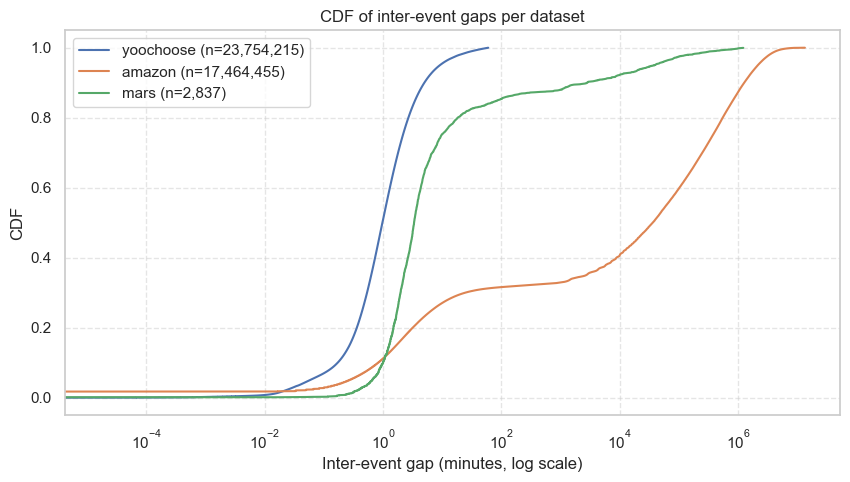

In [5]:
plt.figure(figsize=(10,5))
for name, info in gap_stats.items():
    gaps = info['gaps'].dropna()
    if len(gaps)==0: 
        continue
    gaps_sorted = np.sort(gaps)
    p = np.arange(len(gaps_sorted))/len(gaps_sorted)
    # plot in minutes for readability
    plt.plot(gaps_sorted/60, p, label=f"{name} (n={len(gaps_sorted):,})")
plt.xscale('log')
plt.xlabel("Inter-event gap (minutes, log scale)")
plt.ylabel("CDF")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.title("CDF of inter-event gaps per dataset")
plt.show()


##### Dataset Comparison

By observing where each curve reaches a certain CDF value (e.g., 0.5 or 0.8), you can compare the typical timing of events for each dataset:

yoochoose (Blue Line): This dataset has the shortest inter-event gaps.The curve rises very steeply, indicating that most events are clustered close together in time.A CDF of 0.8 (or 80%) is reached at an inter-event gap of roughly 1 minute ($10^0$). This means 80% of all gaps are 1 minute or less.

mars (Green Line): This dataset shows gaps that are generally longer than yoochoose but shorter than amazon.A CDF of 0.8 is reached around $10^1$ minutes (10 minutes).


amazon (Orange Line): This dataset has the longest and most spread-out inter-event gaps.It takes a gap of about $10^5$ minutes (roughly 70 days) to reach a CDF of 0.8. This signifies that events in the Amazon dataset happen much less frequently and are much more temporally separated compared to the other two.

In short, the plot shows the yoochoose dataset is characterized by a high frequency of very short gaps, while amazon has a much lower frequency, with gaps often spanning days or months.

#### 4 — Compare sessionization effects for different gap thresholds

For Amazon we will compare a few candidate gaps and report:
- #sessions (approx) if we split by gap
- median session length (items)
- percent of sessions with length >=2

This is a simulation: split user's timeline at every gap > threshold.


In [6]:
def simulate_session_stats(df, gap_seconds, user_col='user_id', time_col='timestamp'):
    # df should be sorted by user/time
    df = df.sort_values([user_col, time_col]).copy()
    df['prev_ts'] = df.groupby(user_col)[time_col].shift(1)
    df['gap_s'] = (df[time_col] - df['prev_ts']).dt.total_seconds()
    df['new_sess'] = (df['gap_s'].isna()) | (df['gap_s'] > gap_seconds)
    df['sess_idx'] = df.groupby(user_col)['new_sess'].cumsum().astype(int)
    df['sim_session_id'] = df[user_col].astype(str) + "__s" + df['sess_idx'].astype(str)
    sess = df.groupby('sim_session_id').agg(
        user_id=(user_col,'first'),
        length=('item_id','size'),
        start=(time_col,'min'),
        end=(time_col,'max')
    ).reset_index()
    sess['duration_s'] = (sess['end'] - sess['start']).dt.total_seconds()
    return sess

# Choose candidate gaps to try for Amazon and MARS
candidates_amazon = {
    "1h": 60*60,
    "24h": 24*3600,
    "7d": 7*24*3600,
    "30d": 30*24*3600
}
candidates_mars = {
    "30m": 30*60,
    "1h": 60*60,
    "3h": 3*60*60
}

print("Amazon candidates:")
amazon_df = datasets['amazon']
for k,sec in candidates_amazon.items():
    sess = simulate_session_stats(amazon_df, sec)
    print(f"{k}: sessions={len(sess):,}, median_len={sess['length'].median():.1f}, pct_len>=2={(sess['length']>=2).mean():.4f}")

print("\nMARS candidates:")
mars_df = datasets['mars']
for k,sec in candidates_mars.items():
    sess = simulate_session_stats(mars_df, sec)
    print(f"{k}: sessions={len(sess):,}, median_len={sess['length'].median():.1f}, pct_len>=2={(sess['length']>=2).mean():.4f}")


Amazon candidates:
1h: sessions=21,621,909, median_len=1.0, pct_len>=2=0.1290
24h: sessions=21,192,409, median_len=1.0, pct_len>=2=0.1401
7d: sessions=19,954,022, median_len=1.0, pct_len>=2=0.1658
30d: sessions=18,070,303, median_len=1.0, pct_len>=2=0.1945

MARS candidates:
30m: sessions=1,322, median_len=1.0, pct_len>=2=0.4244
1h: sessions=1,275, median_len=1.0, pct_len>=2=0.4306
3h: sessions=1,202, median_len=1.0, pct_len>=2=0.4393


#### 5 — Visualize example session timelines

Plot a small sample of session timelines (events positioned by seconds since session start).
This is useful for manual inspection.


Sample Amazon sessions (30d gap): ['AHZZZYCUOTRYW4ZQFIFAEZGBOY4A__s1', 'AG22JVQ2EX2EFCEO4IANMERN52AA__s6', 'AGSP6LSQK32SQEJO3YVVNACPWMSQ__s17']


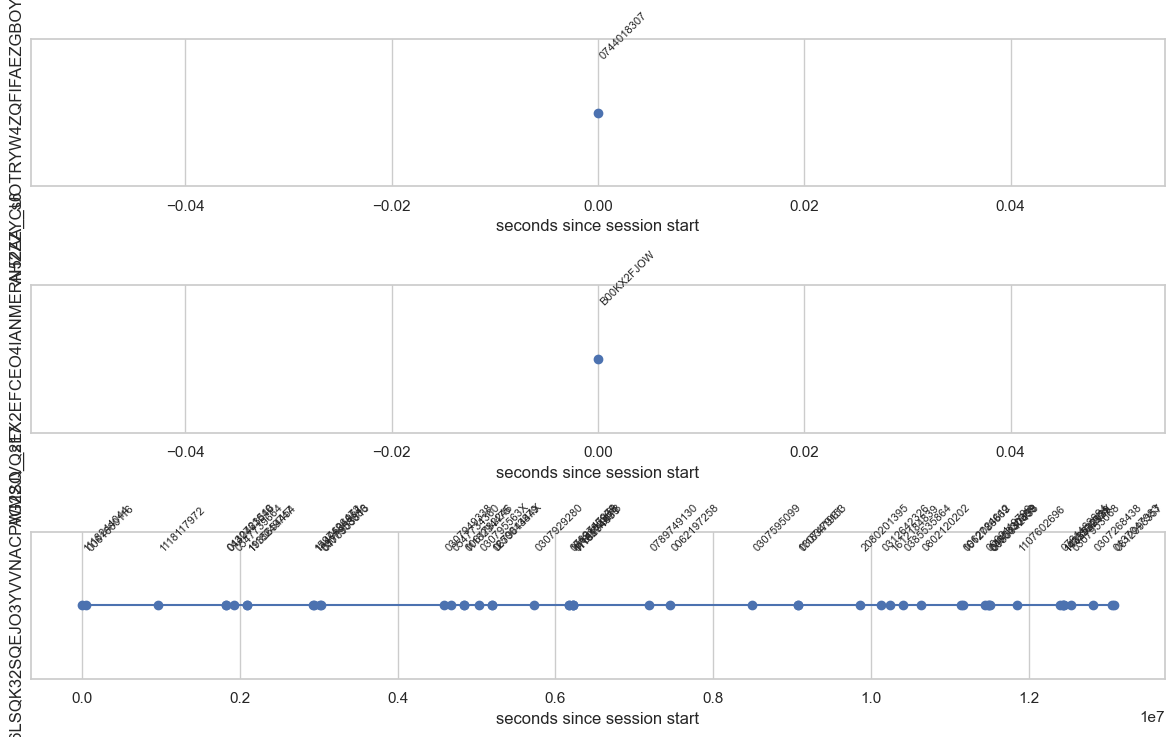

In [7]:
def plot_session_timelines(df, session_ids, max_events=50):
    """
    df: interactions with 'session_id' (simulated or real), 'timestamp', 'item_id'
    session_ids: list of session identifiers to plot
    """
    rows = []
    for s in session_ids:
        g = df[df['sim_session_id']==s].sort_values('timestamp').head(max_events)
        if g.empty: continue
        start = g['timestamp'].min()
        items = g['item_id'].astype(str).tolist()
        times = (g['timestamp'] - start).dt.total_seconds().tolist()
        rows.append((s, items, times))
    n = len(rows)
    if n==0:
        print("No sessions to plot")
        return
    fig, ax = plt.subplots(nrows=n, ncols=1, figsize=(12, max(2.5*n, 4)))
    if n==1:
        ax = [ax]
    for i, (s, items, times) in enumerate(rows):
        y = 0.5
        ax[i].plot(times, [y]*len(times), marker='o')
        for j, t in enumerate(times):
            ax[i].text(t, y+0.02, items[j], rotation=45, fontsize=8)
        ax[i].set_ylabel(s)
        ax[i].set_yticks([])
        ax[i].set_xlabel("seconds since session start")
    plt.tight_layout()
    plt.show()

# Prepare sample: simulate session IDs for Amazon with 30d gap and pick a few long/short ones
sess_amz_30d = simulate_session_stats(amazon_df, 30*24*3600)
# pick some sessions: shortest, median, longest
sess_amz_30d_sorted = sess_amz_30d.sort_values('length')
sample_sessions = list(sess_amz_30d_sorted['sim_session_id'].iloc[[0, int(len(sess_amz_30d_sorted)/2), -1]].values)
# Build df with sim_session_id to pass to plotting
amazon_simdf = amazon_df.sort_values(['user_id','timestamp']).copy()
amazon_simdf['prev_ts'] = amazon_simdf.groupby('user_id')['timestamp'].shift(1)
amazon_simdf['gap_s'] = (amazon_simdf['timestamp'] - amazon_simdf['prev_ts']).dt.total_seconds()
amazon_simdf['new_sess'] = (amazon_simdf['gap_s'].isna()) | (amazon_simdf['gap_s'] > 30*24*3600)
amazon_simdf['sess_idx'] = amazon_simdf.groupby('user_id')['new_sess'].cumsum().astype(int)
amazon_simdf['sim_session_id'] = amazon_simdf['user_id'].astype(str) + "__s" + amazon_simdf['sess_idx'].astype(str)

print("Sample Amazon sessions (30d gap):", sample_sessions)
plot_session_timelines(amazon_simdf, sample_sessions)


#### 6 — Summary & Recommended session gaps

From the empirical checks and CDFs:
- **Amazon Books 2023**: extremely long gaps; short gaps (1h, 30m) fragment users into mostly single-event sessions.
  - **Recommended gap: 30 days (2592000 seconds)** — groups reviews/purchases into meaningful "reading/purchase episodes".
- **MARS (MOOC)**: short interactions, students have bursty sessions.
  - **Recommended gap: 1 hour (3600 seconds)**.
- **YOOCHOOSE**: already sessionized; continue to use the original `session_id`.

We will use these constants going forward in `05_sessionization_and_prefix_target.ipynb`.


In [8]:
# Cell: Save recommended constants for later notebooks (optional)
recommendations = {
    "yoochoose": None,   # use provided
    "amazon": 30*24*3600,  # 30 days
    "mars": 60*60  # 1 hour
}
import json
with open("../data/processed/session_gap_recommendations.json", "w") as f:
    json.dump(recommendations, f)
print("Saved session gap recommendations to ../data/processed/session_gap_recommendations.json")


Saved session gap recommendations to ../data/processed/session_gap_recommendations.json


1) Quick summary of what you found

YOOCHOOSE: gaps concentrated under minutes; sessionization is correct and sessions are short. 

MARS: gaps are short/medium; with 1 hour gap you get ~1.28k sessions and ~43% sessions with length ≥ 2. Reasonable as target domain. 

Amazon (Books 2023): extremely sparse. Even with 30-day gap you get ~18M sessions and only ~19.5% sessions have length ≥ 2 (median session length = 1). This means simple time-gap splitting produces mostly single-event sessions — not useful for next-item sequence models.

2) Problem to address before sessionization/prefix→target generation

If we run 05_sessionization_and_prefix_target.ipynb on Amazon as-is you'll generate huge numbers of session_ids and mostly single-item sessions → very few training pairs, wasted disk, and bad pretraining. We must instead convert Amazon into sequence-friendly training examples.



#### 7 — Next steps

1. These are the gap constants for `05_sessionization_and_prefix_target.ipynb`:
   - `SESSION_GAP_AMAZON = 30 * 24 * 3600`
   - `SESSION_GAP_MARS = 60 * 60`
2. We will run the full sessionization and prefix→target generation with those gaps, save outputs, and run a quick training smoke-test on a small sample to verify data loaders and model code.
